In [2]:
from fastai import *
from fastai.vision import *

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
import matplotlib.pyplot as plt

In [5]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

In [6]:
img.shape

(160, 178, 3)

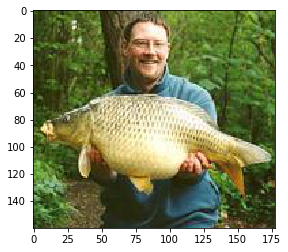

In [7]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [60]:
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

In [94]:
files = os.listdir('/home/thiagodma/.fastai/data/imagenette-160/train/n01440764')

In [128]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [344]:
class CustomDataset(Dataset):
    def __init__(self,root, files, window_size=30, tfms=None):
        self.root = root
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb;pdb.set_trace()
        img = io.imread(self.root + '/' + self.files[idx])
        #import pdb;pdb.set_trace()
        #img = img.transpose((2,0,1))
        #img = torch.from_numpy(img)
        
        if self.tfms: 
            #import pdb;pdb.set_trace()
            img = self.tfms(Image.fromarray(img))
            #import pdb;pdb.set_trace()

        
        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = 0
        sample = (img_window,target)
        
        return sample

In [345]:
tfms = transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [346]:
train_ds = CustomDataset('/home/thiagodma/.fastai/data/imagenette-160/train/n01440764',files_train,tfms=tfms)
valid_ds = CustomDataset('/home/thiagodma/.fastai/data/imagenette-160/train/n01440764',files_val,tfms=tfms)

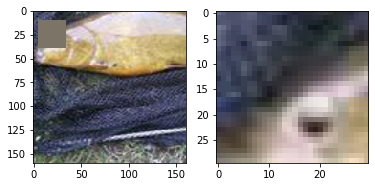

In [347]:
train_ds.show(0)

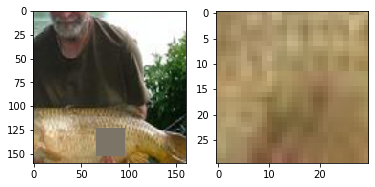

In [355]:
valid_ds.show(1)

In [356]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [357]:
inputs, classes = next(iter(train_dl))

In [358]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 30, 30]))

## 2. Creating the model

In [359]:
mdl = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/thiagodma/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:10<00:00, 4.56MB/s]


In [360]:
mdl

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [361]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(512,256,kernel_size=(3,3),stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(256,128,kernel_size=(3,3),stride=(1,1), padding=(1,1), bias=False)